In [12]:
import math
import numpy as np
import pandas as pd
from analytic_wfm import peakdetect_spline
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline, UnivariateSpline
from sklearn.neighbors import KernelDensity
from FlowCytometryTools import FCMeasurement
from statsmodels.distributions.empirical_distribution import ECDF
# from jupyterthemes import jtplot
# jtplot.style(theme='chesterish')

In [13]:
fcs_dir = 'C:/Users/lzoeckler/Desktop/maria_data/Archive_facs'

In [14]:
test = FCMeasurement(ID='', datafile='{}/1.fcs'.format(fcs_dir))
fcs_data = test.data
fcs_channels = test.channels

Encountered an illegal utf-8 byte in the header.
 Illegal utf-8 characters will be ignored.
'utf-8' codec can't decode byte 0xaa in position 101: invalid start byte
Encountered an illegal utf-8 byte in the header.
 Illegal utf-8 characters will be ignored.
'utf-8' codec can't decode byte 0xaa in position 101: invalid start byte


In [15]:
print(len(fcs_data), 'observations')
print(type(fcs_data))
test.channels

10000 observations
<class 'pandas.core.frame.DataFrame'>


,$PnN,$PnR,$PnB,$PnE,$PnS
Channel Number,,,,,
1,FSC-H,1024,16,"[0, 0]",FSC-Height
2,SSC-H,1024,16,"[0, 0]",SSC-Height
3,FL1-H,1024,16,"[4, 0]",FITC
4,FL2-H,1024,16,"[4, 0]",None
5,FL3-H,1024,16,"[4, 0]",None
6,FL1-A,1024,16,"[0, 0]",None
7,FL4-H,1024,16,"[4, 0]",None


In [16]:
fcs_data.head()

,FSC-H,SSC-H,FL1-H,FL2-H,FL3-H,FL1-A,FL4-H
0,395.0,205.0,468.0,416.0,419.0,13.0,451.0
1,237.0,385.0,516.0,453.0,454.0,22.0,470.0
2,190.0,148.0,552.0,477.0,489.0,32.0,527.0
3,487.0,169.0,579.0,529.0,553.0,41.0,553.0
4,419.0,185.0,525.0,465.0,470.0,25.0,512.0


In [17]:
test = fcs_data.loc[fcs_data['FL1-A'] > 0]
test = test[['FSC-H', 'SSC-H', 'FL1-A']]
test['FL1-A'] = test['FL1-A'].apply(math.log)
test.head()

,FSC-H,SSC-H,FL1-A
0,395.0,205.0,2.564949
1,237.0,385.0,3.091042
2,190.0,148.0,3.465736
3,487.0,169.0,3.713572
4,419.0,185.0,3.218876


In [18]:
FSC_ecdf = ECDF(test['FSC-H'])
test['FSC-H'] = FSC_ecdf(test['FSC-H'])
SSC_ecdf = ECDF(test['SSC-H'])
test['SSC-H'] = SSC_ecdf(test['SSC-H'])
test.head()

,FSC-H,SSC-H,FL1-A
0,0.787215,0.648359,2.564949
1,0.366547,0.883353,3.091042
2,0.264206,0.452781,3.465736
3,0.970988,0.536715,3.713572
4,0.853341,0.590336,3.218876


In [19]:
fsc_filt = (.4, .95)
ssc_filt = (.05, .6)
sub_filter1 = (test['FSC-H'] >= fsc_filt[0])
sub_filter2 = (test['FSC-H'] <= fsc_filt[1])
sub_test = test.loc[sub_filter1 & sub_filter2]
ssc_filter = (test['SSC-H'] >= ssc_filt[0]) & (test['SSC-H'] <= ssc_filt[1])
sub_test = sub_test.loc[ssc_filter]
sub_test.head()

,FSC-H,SSC-H,FL1-A
4,0.853341,0.590336,3.218876
6,0.915066,0.449080,2.484907
7,0.703481,0.405362,2.639057
8,0.889156,0.494398,3.367296
9,0.585434,0.417167,2.079442


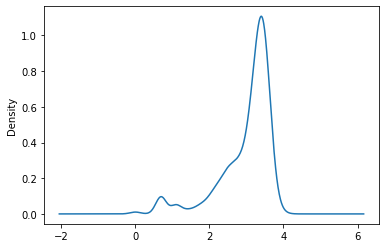

In [21]:
sub_test['FL1-A'].plot.kde()

In [22]:
fl1h = sub_test['FL1-A'].as_matrix()
density = gaussian_kde(fl1h).evaluate(fl1h)
sub_test['density'] = density
d_sum = sub_test['density'].sum()
sub_test['freq'] = sub_test['density'].apply(lambda x: x / d_sum)
fl1h_max = sub_test['FL1-A'].max()
sub_test['intensity'] = sub_test['FL1-A'].apply(lambda x: 100 * (x / fl1h_max))
sub_test.drop_duplicates(['FL1-A', 'density', 'freq', 'intensity'],
                         inplace=True)
sub_test.sort_values('intensity', inplace=True)
sub_test.head()

C:\Users\lzoeckler\miniconda3\envs\DIAMETER\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


,FSC-H,SSC-H,FL1-A,density,freq,intensity
206,0.617547,0.340136,0.000000,0.010357,0.000005,0.000000
22,0.527611,0.266807,0.693147,0.096652,0.000045,16.861310
10,0.472789,0.064026,1.098612,0.052205,0.000024,26.724544
161,0.620948,0.309724,1.386294,0.028889,0.000013,33.722620
508,0.521909,0.320428,1.609438,0.039588,0.000018,39.150749


In [23]:
intense = sub_test['intensity'].values
dense = sub_test['density'].values
freq = sub_test['freq'].values

In [24]:
smooth_spline = CubicSpline(sub_test['intensity'], sub_test['freq'])
spline_derivative = smooth_spline.derivative()
den_x = smooth_spline(sub_test['density'])
intense_x = smooth_spline(sub_test['intensity'])
freq_x = smooth_spline(sub_test['freq'])

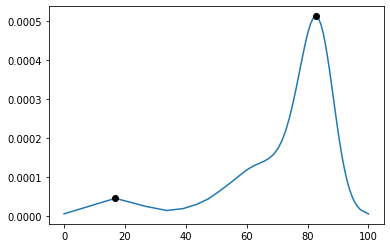

In [25]:
peaks1, properties1 = find_peaks(freq_x)
x_vals = intense[peaks1]
y_vals = freq[peaks1]
plt.plot(intense, freq)
plt.plot(x_vals, y_vals, "o", color='k')

In [26]:
x_vals

array([16.86130987, 82.73660283])

In [27]:
y_vals

array([4.46245832e-05, 5.11488284e-04])

In [14]:
peaks_data = sub_test.loc[sub_test['freq'].isin(y_vals)]
peaks_data = peaks_data.loc[peaks_data['intensity'].isin(x_vals)]
peaks_data = peaks_data.loc[peaks_data['freq'] > .00003]
peaks_data = peaks_data.loc[peaks_data['intensity'] < 99]
peaks_data.head()

,FSC-H,SSC-H,FL1-A,density,freq,intensity
22,0.527611,0.266807,0.693147,0.096652,0.000045,16.861310
90,0.732593,0.405362,3.401197,1.107829,0.000511,82.736603


In [15]:
max_int = max(peaks_data['intensity'])
len_condition = len(peaks_data.loc[peaks_data['intensity'] > max_int - 10])
if len_condition == len(peaks_data):
    maxima = [max_int]
else:
    min_int = min(peaks_data['intensity'])
    maxima = [min_int, max_int]
    maxima_mean = sum(maxima) / len(maxima)
    abs_condition = abs(sub_test['intensity'] - maxima_mean)
    min_condition = min(abs_condition)
    mean_data = sub_test.loc[abs_condition == min_condition]
    meanidx = max(mean_data['intensity'])

In [16]:
maxima

[16.861309868950112, 82.7366028255924]

In [17]:
meanidx

50.58392960685033

In [18]:
mean_data

,FSC-H,SSC-H,FL1-A,density,freq,intensity
9,0.585434,0.417167,2.079442,0.130607,0.00006,50.58393


In [19]:
if len(maxima) == 2:
    upper_freq = sub_test.loc[sub_test['intensity'] >= meanidx,
                              'freq']
    bc_percent = round((100 * upper_freq.sum()), 1)
elif (len(maxima) == 1) & (maxima[0] > 75):
    exp_log_maxima = math.exp(math.log(maxima[0]) - .15)
    abs_condition = abs(sub_test['intensity'] - exp_log_maxima)
    min_condition = min(abs_condition)
    exp_log_data = sub_test.loc[abs_condition == min_condition]
    exp_log_val = max(exp_log_data['intensity'])
    exp_log_freq = exp_log_data.loc[
        exp_log_data['intensity'] >= exp_log_val, 'freq']
    bc_percent = round((100 * exp_log_freq.sum()), 1)
elif (len(maxima) == 1) & (maxima[0] <= 75):
    exp_log_maxima = math.exp(math.log(maxima[0]) + .15)
    abs_condition = abs(sub_test['intensity'] - exp_log_maxima)
    min_condition = min(abs_condition)
    exp_log_data = sub_test.loc[abs_condition == min_condition]
    exp_log_val = max(exp_log_data['intensity'])
    exp_log_freq = exp_log_data.loc[
        exp_log_data['intensity'] >= exp_log_val, 'freq']
    bc_percent = round((100 * exp_log_freq.sum()), 1)
else:
    raise ValueError('Something went wrong!')

In [20]:
bc_percent

1.1

In [21]:
mainp = ''.join('{}, '.format(x) for x in maxima)

In [22]:
mainp

'16.861309868950112, 82.7366028255924, '

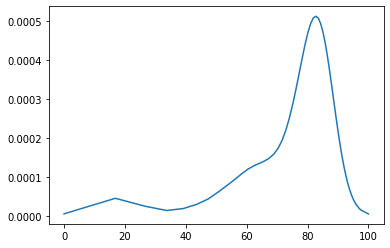

In [23]:
plt.plot(intense, freq)

In [28]:
test = pd.DataFrame(columns=['one', 'two'])
test

,one,two
